# Challenge Cintelink

Historial de inventarios de un tanque de Diesel 500 de 40.000Lts. 

1. ¿De cuánto es el consumo por minuto de este tanque?
2. ¿Cuántos abastecimientos por semana tiene este tanque?
3. Graficar el comportamiento de las variaciones de inventario semanales.
4. Crear un nuevo archivo que contenga las definiciones de tipo de dato y simplifique el data set. 
5. Hacer una presentación de 3-slides con las conclusiones. 

La solución debe estar resuelta en una notebook, en Github. 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# El archivo Excel viene con una pequeña descripción que la voy a almacenar en una variable para usarla después:

descripcion = """
Usuario:	Diego Tondo
Fecha:	25/09/23
Hora:	07:06:55
	
Filtros de Búsqueda	
Desde:	01/07/23
Hasta:	25/09/23
Hasta:	23:59
ID Tanque:	104089
ID Sitio:	1169
"""

In [4]:
# Leemos y vemos algunos registros del dataset:
df = pd.read_excel('Tanque_25-09-2023_07-06-5565115bbf6b37d.xlsx')
df.sample(5, random_state=5)

,ID,ID Sitio,ID Tanque,Tanque,Fecha,Hora,Volumen,Temperatura,Código de Finalización,Eliminado,Salud de Sonda,Carga de Pilas,Fuel level dmm,Water level dmm,Water volume lts,p1_dif_vol,p1_dif_vol_neg,p1_Fecha_hora
4970,718851,1169,104089,2,2023-09-06,11:56:46,15947.450,11.8,V1,0,64,341,10419,0,0,-67.808,-67.808,2023-09-06 11:56:46
23182,664098,1169,104089,2,2023-07-24,10:47:39,15443.923,14.1,V1,0,64,344,10159,0,0,-67.675,-67.675,2023-07-24 10:47:39
18666,677056,1169,104089,2,2023-08-02,11:50:38,10736.880,21.5,V1,0,60,348,7663,0,0,-69.609,-69.609,2023-08-02 11:50:38
10966,700439,1169,104089,2,2023-08-18,09:35:17,28213.258,16.9,V1,0,60,345,16741,0,0,-22.392,-22.392,2023-08-18 09:35:17
10228,702531,1169,104089,2,2023-08-21,11:06:55,6236.400,9.1,V1,0,63,341,5053,0,0,-72.600,-72.600,2023-08-21 11:06:55


### 1. ¿De cuánto es el consumo por minuto de este tanque?

Consumo total

In [5]:
# Elegimos los campos que nos servirán para el cálculo:
df1 = df[['Fecha', 'Hora','Volumen']]
df1.head()

,Fecha,Hora,Volumen
0,2023-09-25,07:00:09,8161.072
1,2023-09-25,06:58:12,8161.072
2,2023-09-25,06:57:13,8162.788
3,2023-09-25,06:56:14,8205.728
4,2023-09-25,06:55:15,8276.084


In [6]:
# El campo 'dif_vol' tendrá la resta de volumenes de una fila y la fila siguiente (el volumen sensado anteriormente).
df1['dif_vol'] = df1['Volumen'] - df1['Volumen'].shift(-1)

# De la diferencia de volumenes 'dif_vol' nos quedamos sólo con los valores negativos, osea, los volumenes que se han consumido.
df1['dif_vol_neg'] = df1['dif_vol'].apply(lambda x: x if x < 0 else None)

df1 = df1.fillna(0)

df1.head()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14452\1441525745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dif_vol'] = df1['Volumen'] - df1['Volumen'].shift(-1)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14452\1441525745.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dif_vol_neg'] = df1['dif_vol'].apply(lambda x: x if x < 0 else None)


,Fecha,Hora,Volumen,dif_vol,dif_vol_neg
0,2023-09-25,07:00:09,8161.072,0.000,0.000
1,2023-09-25,06:58:12,8161.072,-1.716,-1.716
2,2023-09-25,06:57:13,8162.788,-42.940,-42.940
3,2023-09-25,06:56:14,8205.728,-70.356,-70.356
4,2023-09-25,06:55:15,8276.084,-70.906,-70.906


In [7]:
# El consumo total será la suma de los consumos (diferencias de volumen negativo).
consumo_total= df1['dif_vol_neg'].sum()
print('El consumo total es:' , round(abs(consumo_total),2), 'litros')

El consumo total es: 632780.64 litros


Tiempo total

In [8]:
# Para calcular el consumo por minuto tenemos que saber cuánto tiempo paso desde la primer hasta la última medición.
# Para esto, primero creamos un campo nuevo que contenga tanto la fecha como la hora:
df1['Fecha_hora'] = df1['Fecha'] + ' ' + df1['Hora']

# Lo pasamos al tipo de dato datetime:
df1['Fecha_hora'] = pd.to_datetime(df1['Fecha_hora'])

# Accedemos a la última fecha (el primer registro):
ultima_fecha = df1['Fecha_hora'][0]

# Y accedemos a la primer fecha (último registro):
primera_fecha = df1['Fecha_hora'][df1.shape[0]-1]

# Hacemos la diferencia de fechas, lo que nos dará un intervalo de tiempo:
dif_fecha = ultima_fecha-primera_fecha

# Pasamos el intervalo de tiempo a segundos
total_segundos = dif_fecha.total_seconds()

# Dividimos los segundos por 60 para tener la cantidad de minutos:
total_minutos = total_segundos/60
print('El total de minutos es:' , total_minutos, 'minutos.')

El total de minutos es: 124259.33333333333 minutos.


Consumo por minuto

In [9]:
# El consumo por minutos será la división entre el consumo total y el total de minutos transcurridos:
consumo_minuto = round(abs(consumo_total)/total_minutos,2)
print('El consumo por minuto es' , consumo_minuto , 'litros por minuto.')

El consumo por minuto es 5.09 litros por minuto.


### 2.¿Cuántos abastecimientos por semana tiene este tanque?

In [10]:
# Seleccionamos los datos que nos interesan para el análisis:
df2 = df[['Fecha', 'Hora','Volumen']]

# El campo 'dif_vol' tendrá la resta de volumenes de una fila y la fila siguiente (el volumen sensado anteriormente).
df2['dif_vol'] = df2['Volumen'] - df2['Volumen'].shift(-1)

# Como nos interesa sólo los abastecimientos y no el consumo, descartamos aquellas variaciones negativas.
df2['dif_vol_pos'] = df2['dif_vol'].apply(lambda x: x if x > 0 else None)

# Estuve viendo los valores en Excel y se repite mucho 1.966 de forma esporádica y sin seguir ningún patrón, por lo que se lo toma como un error de medición.
df2['dif_vol_pos'].mode()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_14452\1349577770.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['dif_vol'] = df2['Volumen'] - df2['Volumen'].shift(-1)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14452\1349577770.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['dif_vol_pos'] = df2['dif_vol'].apply(lambda x: x if x > 0 else None)


0    1.966
Name: dif_vol_pos, dtype: float64

In [11]:
# Elevamos el umbral para no tener ese error.
df2['dif_vol_pos'] = df2['dif_vol'].apply(lambda x: x if x > 2 else None)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14452\2850458636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['dif_vol_pos'] = df2['dif_vol'].apply(lambda x: x if x > 2 else None)


In [12]:
# Agrupa por 'Fecha' y suma las diferencias de volumen positivas
df2_daily = df2.groupby('Fecha')['dif_vol_pos'].sum().reset_index()
# Al hacer esto descartamos la posibilidad de que haya más de una carga por día, pero por ahora no se me ocurre otra forma de calcularlo.

# Pasamos 'Fecha' a tipo datetime:
df2_daily['Fecha'] = pd.to_datetime(df2_daily['Fecha'])

# Creamos la columna 'Semana_del_Año':
df2_daily['Semana_del_Año'] = df2_daily['Fecha'].dt.strftime('%U')

# Filtramos las filas donde dif_vol_pos es distinto de cero y luego contamos las filas por semana:
df2_weekly = df2_daily[df2_daily['dif_vol_pos'] != 0].groupby('Semana_del_Año')['dif_vol_pos'].count().reset_index()

# Cambiar el nombre de la columna a 'Cantidad_valores_distintos_de_cero'
df2_weekly.rename(columns={'dif_vol_pos': 'Cantidad de abastecimientos por semana'}, inplace=True)
df2_weekly

,Semana_del_Año,Cantidad de abastecimientos por semana
0,26,1
1,27,6
2,28,7
3,29,7
4,30,7
5,31,7
6,32,7
7,33,6
8,34,7
9,35,6


In [13]:
print('Promedio de abastecimientos por semana:' , round(df2_weekly['Cantidad de abastecimientos por semana'].mean(),2))

Promedio de abastecimientos por semana: 5.64


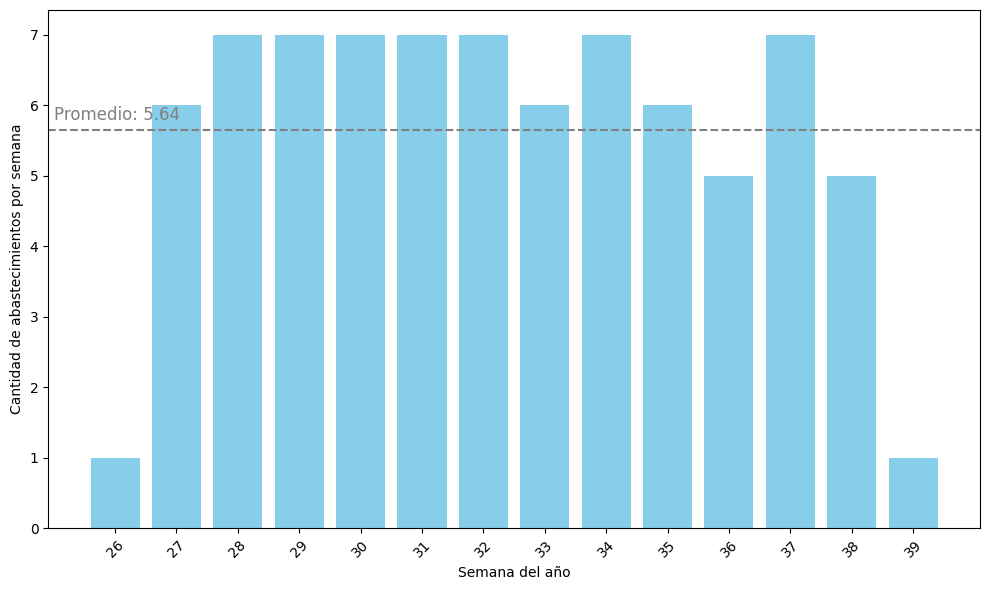

In [14]:
# Graficamos los abastecimientos por semana y el promedio:
promedio = df2_weekly['Cantidad de abastecimientos por semana'].mean()

plt.figure(figsize=(10, 6))
plt.bar(df2_weekly['Semana_del_Año'], df2_weekly['Cantidad de abastecimientos por semana'], color='skyblue', label='Abastecimientos por Semana')
plt.axhline(df2_weekly['Cantidad de abastecimientos por semana'].mean(), color='grey', linestyle='--', label='Promedio')
plt.xlabel('Semana del año')
plt.ylabel('Cantidad de abastecimientos por semana')
plt.text(-1, promedio+ 0.15, f'Promedio: {promedio:.2f}', color='grey', fontsize=12)
plt.xticks(rotation=45)  
plt.tight_layout()

plt.show()


### 3. Graficar el comportamiento de las variaciones de inventario semanales.

In [15]:
# Seleccionamos los campos que nos servirán para el análisis.
df3 = df[['Fecha', 'Hora','Volumen']]

# Pasamos 'Fecha' a tipo datetime:
df3['Fecha'] = pd.to_datetime(df3['Fecha'])

# Creamos la columna 'Semana_del_Año':
df3['Semana_del_Año'] = df3['Fecha'].dt.strftime('%U')

# Agrupamos segun 'Semana_del_Año' y calculamos la media por cada grupo:
for semana, group_df in df3.groupby('Semana_del_Año'):
    mean_volume = group_df['Volumen'].mean()
    print(f'Semana {semana}: Promedio de volumen = {mean_volume}')

Semana 26: Promedio de volumen = 19054.542395348835
Semana 27: Promedio de volumen = 19562.027059675747
Semana 28: Promedio de volumen = 14482.641999288004
Semana 29: Promedio de volumen = 17707.89047342026
Semana 30: Promedio de volumen = 20467.437695652177
Semana 31: Promedio de volumen = 12222.524500383928
Semana 32: Promedio de volumen = 16928.96584554974
Semana 33: Promedio de volumen = 20919.23274584615
Semana 34: Promedio de volumen = 13558.854065757816
Semana 35: Promedio de volumen = 8521.976860159552
Semana 36: Promedio de volumen = 10293.478618874771
Semana 37: Promedio de volumen = 15753.82731848659
Semana 38: Promedio de volumen = 11132.607869631127
Semana 39: Promedio de volumen = 8488.458863013699


C:\Users\Usuario\AppData\Local\Temp\ipykernel_14452\1082977188.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Fecha'] = pd.to_datetime(df3['Fecha'])
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14452\1082977188.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Semana_del_Año'] = df3['Fecha'].dt.strftime('%U')


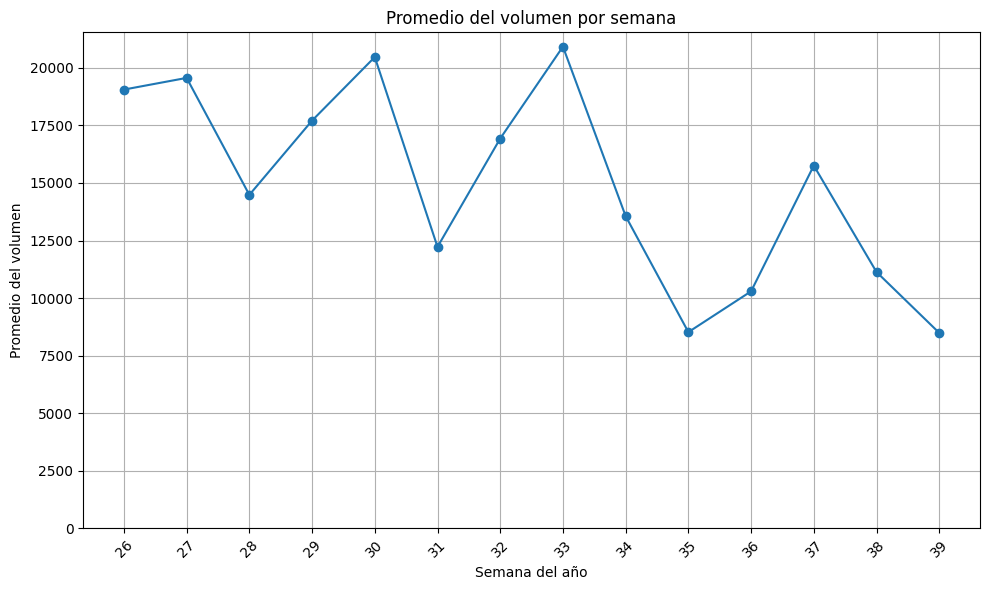

In [16]:
semanas = []
medias_volumen = []

for semana, group_df in df3.groupby('Semana_del_Año'):
    semanas.append(semana)
    medias_volumen.append(group_df['Volumen'].mean())

# Crear un gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(semanas, medias_volumen, marker='o', linestyle='-')
plt.xlabel('Semana del año')
plt.ylabel('Promedio del volumen')
plt.title('Promedio del volumen por semana')
plt.xticks(rotation=45)
plt.grid(True)

# Establecer el límite mínimo del eje y en 0
plt.ylim(ymin=0)


    
# Mostrar el gráfico
plt.tight_layout()
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14452\2488606236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['dif_vol'] = df3['Volumen'] - df3['Volumen'].shift(-1)


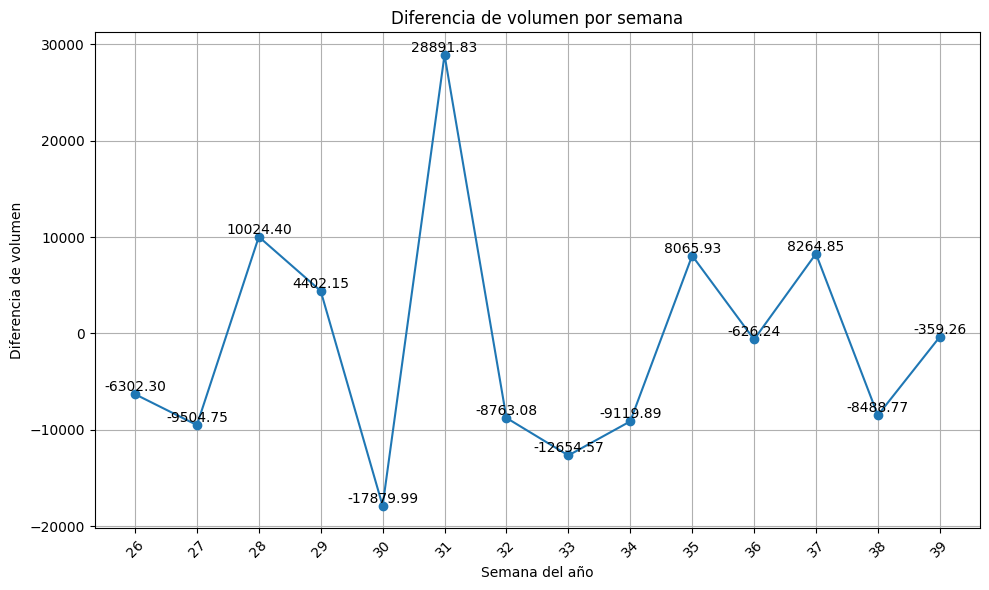

In [17]:
# El campo 'dif_vol' tendrá la resta de volumenes de una fila y la fila siguiente (el volumen sensado anteriormente).
df3['dif_vol'] = df3['Volumen'] - df3['Volumen'].shift(-1)

semanas = []
suma_diferencia_vol = []

for semana, group_df in df3.groupby('Semana_del_Año'):
    semanas.append(semana)
    suma_diferencia_vol.append(group_df['dif_vol'].sum())

# Crear un gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(semanas, suma_diferencia_vol, marker='o', linestyle='-')
plt.xlabel('Semana del año')
plt.ylabel('Diferencia de volumen')
plt.title('Diferencia de volumen por semana')
plt.xticks(rotation=45)
plt.grid(True)

# Agregar etiquetas de texto para los valores en cada punto
for semana, suma_vol in zip(semanas, suma_diferencia_vol):
    plt.text(semana, suma_vol, f'{suma_vol:.2f}', ha='center', va='bottom')
    
# Mostrar el gráfico
plt.tight_layout()
plt.show()

### 4. Crear un nuevo archivo que contenga las definiciones de tipo de dato y simplifique el data set. 

In [18]:
tipos_de_datos = df.dtypes
tipos_de_datos

ID                                 int64
ID Sitio                           int64
ID Tanque                          int64
Tanque                             int64
Fecha                             object
Hora                              object
Volumen                          float64
Temperatura                      float64
Código de Finalización            object
Eliminado                          int64
Salud de Sonda                     int64
Carga de Pilas                     int64
Fuel level dmm                     int64
Water level dmm                    int64
Water volume lts                   int64
p1_dif_vol                       float64
p1_dif_vol_neg                   float64
p1_Fecha_hora             datetime64[ns]
dtype: object

In [19]:
df.nunique()[df.nunique() == 1]
# Podemos simplificar el dataset borrando los siguientes campos, ya que contienen valores únicos que podrían estar junto con la descripción del dataset.

ID Sitio            1
ID Tanque           1
Tanque              1
Eliminado           1
Water level dmm     1
Water volume lts    1
dtype: int64

In [20]:
# Campos con valores únicos: 
constant_columns = df.columns[df.nunique() == 1]
constant_columns

Index(['ID Sitio', 'ID Tanque', 'Tanque', 'Eliminado', 'Water level dmm',
       'Water volume lts'],
      dtype='object')

In [21]:
# Iteramos a través de las columnas con valores constantes e imprimimos un valor de cada una:
for column_name in constant_columns:
    constant_value = df[column_name].iloc[0]  
    print(f" {column_name} : {constant_value}")
# Vemos que algunos campos ya están en la descripción adjunta al dataset:

 ID Sitio : 1169
 ID Tanque : 104089
 Tanque : 2
 Eliminado : 0
 Water level dmm : 0
 Water volume lts : 0


In [22]:
# Le agregamos a la descripcion la información de los campos con valores únicos:
descripcion = """
Usuario:	Diego Tondo
Fecha:	25/09/23
Hora:	07:06:55
	
Filtros de Búsqueda	
Desde:	01/07/23
Hasta:	25/09/23
Hasta:	23:59
ID Tanque:	104089
ID Sitio:	1169
Tanque : 2
Eliminado : 0
Water level dmm : 0
Water volume lts : 0

"""

In [23]:
# Visualizamos el dataframe simplificado:
columnas_a_dropear = df.nunique()[df.nunique() == 1].index
df4 = df.drop(columnas_a_dropear, axis=1)
df4

,ID,Fecha,Hora,Volumen,Temperatura,Código de Finalización,Salud de Sonda,Carga de Pilas,Fuel level dmm,p1_dif_vol,p1_dif_vol_neg,p1_Fecha_hora
0,735552,2023-09-25,07:00:09,8161.072,13.2,U1,64,343,6210,0.000,0.000,2023-09-25 07:00:09
1,735546,2023-09-25,06:58:12,8161.072,13.2,V1,64,343,6210,-1.716,-1.716,2023-09-25 06:58:12
2,735545,2023-09-25,06:57:13,8162.788,13.2,V1,64,343,6211,-42.940,-42.940,2023-09-25 06:57:13
3,735544,2023-09-25,06:56:14,8205.728,13.2,V1,64,343,6236,-70.356,-70.356,2023-09-25 06:56:14
4,735543,2023-09-25,06:55:15,8276.084,13.2,V1,64,343,6277,-70.906,-70.906,2023-09-25 06:55:15
...,...,...,...,...,...,...,...,...,...,...,...,...
32300,634429,2023-07-01,02:00:33,22206.850,15.5,N1,64,344,13611,0.000,0.000,2023-07-01 02:00:33
32301,634425,2023-07-01,01:30:08,22206.850,15.5,N1,64,344,13611,-1.950,-1.950,2023-07-01 01:30:08
32302,634423,2023-07-01,01:00:41,22208.800,15.6,N1,64,344,13612,0.000,0.000,2023-07-01 01:00:41
32303,634419,2023-07-01,00:30:16,22208.800,15.6,N1,64,344,13612,-1.950,-1.950,2023-07-01 00:30:16


C:\Users\Usuario\AppData\Local\Temp\ipykernel_14452\3834401176.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(df4.corr())
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14452\3834401176.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df4.corr(), annot=True, linewidths=0.4,linecolor="white", fmt= '.1f',ax=ax,cmap="Blues",mask=mask)


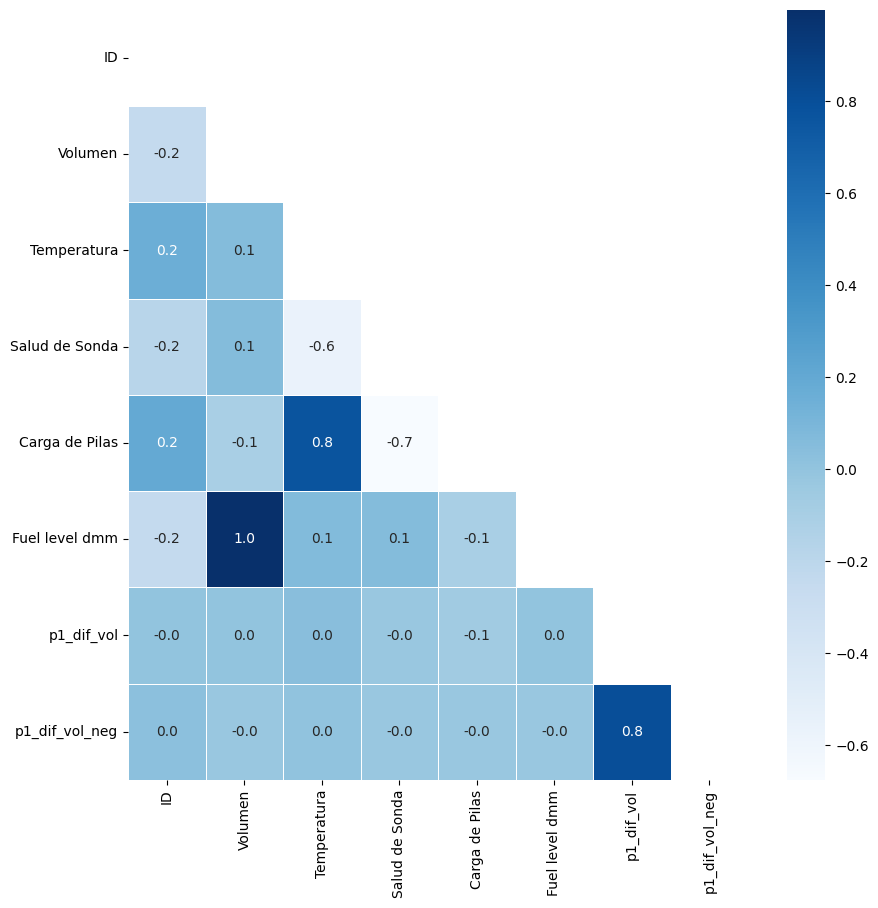

In [24]:
# Vemos si existen relaciones entre las variables que han quedado del dataset:
f,ax = plt.subplots(figsize=(10, 10))
mask = np.zeros_like(df4.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df4.corr(), annot=True, linewidths=0.4,linecolor="white", fmt= '.1f',ax=ax,cmap="Blues",mask=mask)
plt.show() 

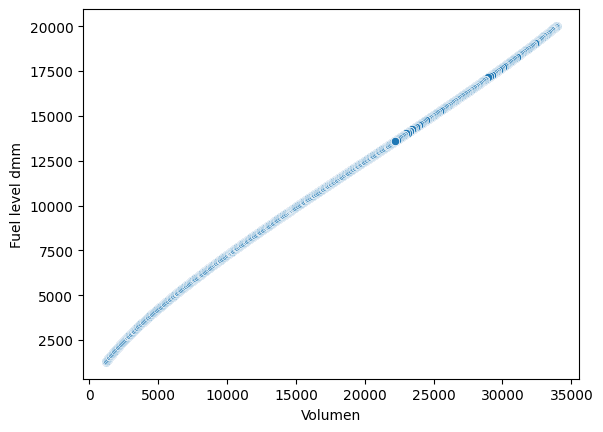

In [25]:
# Vemos la relación entre ambos campos:
sns.scatterplot(x='Volumen', y='Fuel level dmm', data=df4)
plt.show()


In [26]:
correlacion = df['Volumen'].corr(df['Fuel level dmm'])
correlacion

0.9986357601891936

In [27]:
# Pasamos los campos a valores logarítmicos, donde la relación es aún mayor:
df4['log_Volumen'] = np.log(df4['Volumen'])
df4['log_level'] = np.log(df4['Fuel level dmm'])
correlacion_log = df4['log_Volumen'].corr(df4['log_level'])
correlacion_log

0.999799118829064

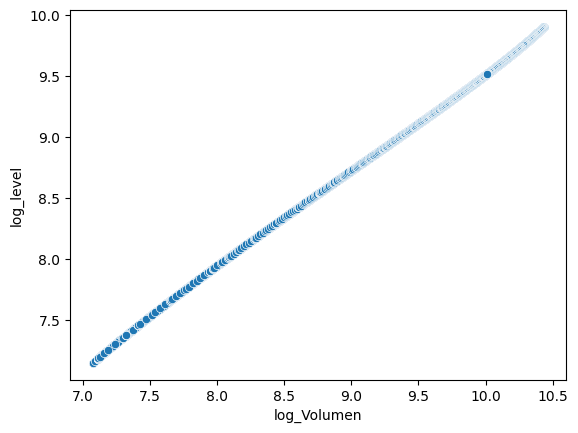

In [28]:
# Graficamos la relación: 
sns.scatterplot(x='log_Volumen', y='log_level', data=df4)
plt.show()

In [29]:
# Por relación directa entre Volumen y Fuel level dmm uno de estos campos es redundante, ya que 
# podemos hacer una función de conversión: teniendo valores de Volumen podemos calcular los valores de Fuel level dmm.

relación_v_lvl = (df4['log_level'].mean()) / (df4['log_Volumen'].mean())

def vol_to_level(volumen):
    level = np.log(volumen) * relación_v_lvl
    return round(np.exp(level),2) 

# Probamos la funcion
vol_to_level(df4['Volumen'][1]) 



5703.86

In [30]:
# Corroboramos la igualdad de valores: 
df4['Fuel level dmm'][1]

6210

In [31]:
# Creamos una nueva columna para corroborar los valores de todos los registros:
df4['Volumen_to_lvl'] = round(np.exp(np.log(df4['Volumen']) * relación_v_lvl),2)

In [32]:
df4['Fuel level dmm'].describe()

count    32305.000000
mean     10083.675406
std       4081.539956
min       1279.000000
25%       7046.000000
50%      10271.000000
75%      13062.000000
max      20021.000000
Name: Fuel level dmm, dtype: float64

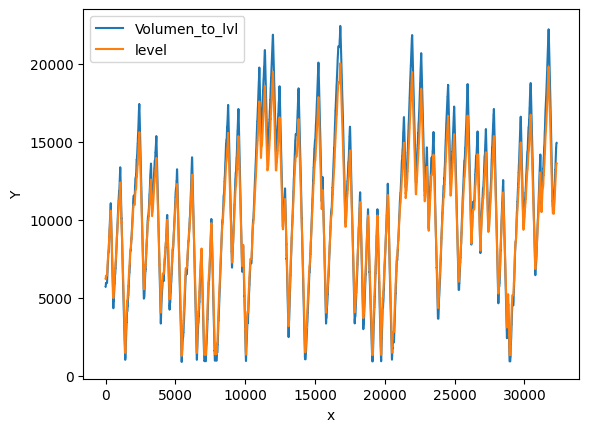

In [33]:

# Graficar las dos columnas como líneas
plt.plot(df4['Volumen_to_lvl'], label='Volumen_to_lvl')
plt.plot(df4['Fuel level dmm'], label='level')

# Agregar etiquetas y leyenda
plt.xlabel('x')
plt.ylabel('Y')
plt.legend()

# Mostrar el gráfico
plt.show()


In [34]:
# Podemos observar que en los extremos los valores difieren un poco, voy a ver si lo puedo solucionar #########################################################################################################################

In [35]:
df4_save = df4[['ID',	'Fecha',	'Hora',	'Volumen',	'Temperatura',	'Código de Finalización',	'Salud de Sonda',	'Carga de Pilas']]
df4_save

,ID,Fecha,Hora,Volumen,Temperatura,Código de Finalización,Salud de Sonda,Carga de Pilas
0,735552,2023-09-25,07:00:09,8161.072,13.2,U1,64,343
1,735546,2023-09-25,06:58:12,8161.072,13.2,V1,64,343
2,735545,2023-09-25,06:57:13,8162.788,13.2,V1,64,343
3,735544,2023-09-25,06:56:14,8205.728,13.2,V1,64,343
4,735543,2023-09-25,06:55:15,8276.084,13.2,V1,64,343
...,...,...,...,...,...,...,...,...
32300,634429,2023-07-01,02:00:33,22206.850,15.5,N1,64,344
32301,634425,2023-07-01,01:30:08,22206.850,15.5,N1,64,344
32302,634423,2023-07-01,01:00:41,22208.800,15.6,N1,64,344
32303,634419,2023-07-01,00:30:16,22208.800,15.6,N1,64,344


In [36]:
# También podemos ver que existe una fuerte relación entre Temperatura y Carga de Pila, pero al no conocer el significado del segundo campo, tomamos el criterio de no predecirlo según Temperatura.
# Lo mismo ocurre para Salud de Sonda y Carga de pila.

In [37]:
# La idea es crear un archivo Excel que contenga la descripción con la que ya vino el archivo original, los tipos de datos del archivo y el df simplificado:

# Primero creamos un nuevo libro de Excel:
workbook = Workbook()
sheet = workbook.active

# Agregamos la descripción a la hoja de Excel:
lines = descripcion.strip().split('\n')
for row, line in enumerate(lines, start=1):
    if ':' in line:
        key, value = line.split(':', 1)
        sheet.cell(row=row, column=2, value=key.strip())
        sheet.cell(row=row, column=3, value=value.strip())
    else:
        sheet.cell(row=row, column=2, value=line.strip())

# Agregamos el texto "Tipos de datos" en la celda B1 (columna 2, fila 1)
sheet.cell(row=16, column=2, value="Tipos de datos")

# Luego, agregamos los tipos de datos debajo del encabezado "Tipos de datos".
for row_idx, col_name in enumerate(df.columns, start=17):
    data_type = tipos_de_datos.get(str(df[col_name].dtype), 'string')
    sheet.cell(row=row_idx, column=2, value=col_name)
    sheet.cell(row=row_idx, column=3, value=data_type)

# Agregamos el df simplificado debajo de los tipos de datos:
for row_idx, row in enumerate(dataframe_to_rows(df4_save, index=False), start=len(lines) + len(tipos_de_datos) + 4):
    for col_idx, value in enumerate(row, start=1):
        sheet.cell(row=row_idx, column=col_idx, value=value)

# Guardamos el archivo el archivo de Excel
workbook.save('df_tanque.xlsx')


<!-- Principal component analysis (PCA) -->

### 5. Hacer una presentación de 3-slides con las conclusiones. 

In [ ]:
# Link al dashboard: https://github.com/scioffi96/Cintelink_challenge/blob/main/Dashboard.pbix